In [1]:
import time
import glob as glob
from zipfile import ZipFile
from bs4 import BeautifulSoup
import dateutil.parser as dparser
from datetime import datetime
import pandas as pd
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

%matplotlib inline

In [2]:
df = pd.read_csv('/home/shane/Documents/thesis/output/final/failures.csv', parse_dates=['timestamp_dir'])
df['operational_pct'] = df['operational_pct'].astype('float') * 100
df['partial_pct'] = df['partial_pct'].astype('float') * 100
df['major_pct'] = df['major_pct'].astype('float') * 100
df['maint_pct'] = df['maint_pct'].astype('float') * 100
df

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,source,service,timestamp_dir,timestamp_site,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
0,slack,slack,2020-03-26 12:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
1,slack,slack,2020-03-26 13:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
2,slack,slack,2020-03-26 14:00:02,NaN,10,100.0,0,0.0,0,0.0,0,0.0
3,slack,slack,2020-03-26 15:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
4,slack,slack,2020-03-26 16:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
403998,cloud-google-cloud-platform,google-cloud,2020-06-10 19:00:02,NaN,1,100.0,0,0.0,0,0.0,0,0.0
403999,cloud-google-cloud-platform,google-cloud,2020-06-10 20:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0
404000,cloud-google-cloud-platform,google-cloud,2020-06-10 21:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0
404001,cloud-google-cloud-platform,google-cloud,2020-06-10 22:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0


## Data validation

#### NaN counts

In [3]:
print(df.isna().sum(),'\n')
print(df.isna().sum().sum())

source                      0
service                     0
timestamp_dir               0
timestamp_site          24646
operational_count           0
operational_pct             8
partial_outage_count        0
partial_pct                 8
major_outage_count          0
major_pct                   8
maint_count                 0
maint_pct                   8
dtype: int64 

24678


#### Find rows with NaN (not including timestamp_site)

In [4]:
df_tmp = df.copy()
df_tmp.drop(['timestamp_site'], axis=1, inplace=True)
is_nan = df_tmp.isnull()
row_has_nan = is_nan.any(axis=1)
nan_rows = df[row_has_nan]
nan_rows

,source,service,timestamp_dir,timestamp_site,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
294985,downdetector-fin-finland,snapchat,2018-09-10 00:00:02,2018-09-10T03:03:04.030439+03:00,0,NaN,0,NaN,0,NaN,0,NaN
317306,downdetector-gbr-great-britain,slack,2018-09-16 02:00:01,2018-09-16T03:01:28.474454+01:00,0,NaN,0,NaN,0,NaN,0,NaN
325877,downrightnow,tumblr,2019-12-01 20:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
328557,downrightnow,netflix,2019-12-08 20:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
328783,downrightnow,gmail,2019-12-09 10:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
335093,downrightnow,linkedin,2019-12-25 20:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
335694,downrightnow,youtube,2019-12-27 10:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
336223,downrightnow,gmail,2019-12-28 19:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN


#### Drop timestamp_site and remaining rows with NaN

In [5]:
df.dropna(inplace=True)
df.drop(['timestamp_site'], axis=1, inplace=True)

## General statistics

#### Sum and percentage of status types

In [6]:
operational_sum = df['operational_count'].sum()
partial_outage_sum = df['partial_outage_count'].sum()
major_outage_sum = df['major_outage_count'].sum()
maintenance_sum = df['maint_count'].sum()

total_sum = operational_sum + partial_outage_sum + major_outage_sum + maintenance_sum

print('operatnl sum:', operational_sum, '\tpct:', operational_sum/total_sum*100)
print('p_outage sum:', partial_outage_sum, '\tpct:', partial_outage_sum/total_sum*100)
print('m_outage sum:', major_outage_sum, '\tpct:', major_outage_sum/total_sum*100)
print('maintnce sum:', maintenance_sum, '\tpct:', maintenance_sum/total_sum*100)

operatnl sum: 2592099 	pct: 93.6637044965172
p_outage sum: 171015 	pct: 6.1795087396244845
m_outage sum: 4179 	pct: 0.1510052745249874
maintnce sum: 160 	pct: 0.005781489333332852


#### Overall averages per source/service grouping

In [7]:
df_mean = df.groupby(['source','service']).agg(mean_op=('operational_pct',np.mean), mean_part=('partial_pct',np.mean), mean_maj=('major_pct',np.mean), mean_maint=('maint_pct',np.mean))
df_mean

mean_op  mean_part  mean_maj  mean_maint
source        service                                                
atlassian     access      100.000000   0.000000  0.000000    0.000000
              bitbucket    99.480476   0.162202  0.081699    0.275623
              confluence   99.456988   0.456774  0.031772    0.054466
              developers   99.877864   0.066020  0.042913    0.013204
              jira-align  100.000000   0.000000  0.000000    0.000000
...                              ...        ...       ...         ...
downrightnow  twitter      99.462366   0.537634  0.000000    0.000000
              typepad     100.000000   0.000000  0.000000    0.000000
              yahoomail    99.596774   0.403226  0.000000    0.000000
              youtube     100.000000   0.000000  0.000000    0.000000
github-status github       99.696415   0.271073  0.032511    0.000000

[186 rows x 4 columns]

#### Daily averages per source/service grouping

In [8]:
df['days'] = df.timestamp_dir.dt.date
df_grp = df.groupby(['source','service','days']).agg({'operational_pct': 'mean', 'partial_pct': 'mean', 'major_pct': 'mean', 'maint_pct': 'mean'})
df_grp

operational_pct  partial_pct  major_pct  \
source        service days                                                  
atlassian     access  2020-03-26       100.000000     0.000000        0.0   
                      2020-03-27       100.000000     0.000000        0.0   
                      2020-03-28       100.000000     0.000000        0.0   
                      2020-03-29       100.000000     0.000000        0.0   
                      2020-03-30       100.000000     0.000000        0.0   
...                                           ...          ...        ...   
github-status github  2020-06-06       100.000000     0.000000        0.0   
                      2020-06-07       100.000000     0.000000        0.0   
                      2020-06-08       100.000000     0.000000        0.0   
                      2020-06-09       100.000000     0.000000        0.0   
                      2020-06-10        98.958333     1.041667        0.0   

                                  maint_pct  
source        service days                   
atlassian     access  2020-03-26        0.0  
                      2020-03-27        0.0  
                      2020-03-28        0.0  
                      2020-03-29        0.0  
                      2020-03-30        0.0  
...                                     ...  
github-status github  2020-06-06        0.0  
                      2020-06-07        0.0  
                      2020-06-08        0.0  
                      2020-06-09        0.0  
                      2020-06-10        0.0  

[16152 rows x 4 columns]

## Figures and plots

In [9]:
sns.set(rc={'figure.figsize':(8,8)})
sns.set(style='white')

#### Boxplot

[Text(0, 0, 'Operational'),
 Text(1, 0, 'Partial Outage'),
 Text(2, 0, 'Major Outage'),
 Text(3, 0, 'Maintenance')]

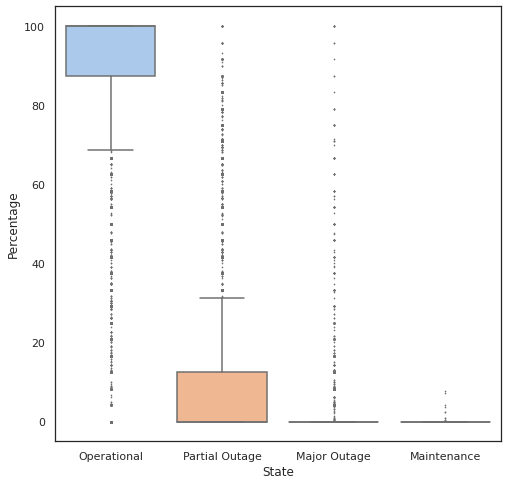

In [10]:
ax = sns.boxplot(x='variable', y='value', palette='pastel', fliersize=0.8, data=pd.melt(df_grp))
ax.set(xlabel='State', ylabel='Percentage')
ax.set_xticklabels(['Operational', 'Partial Outage', 'Major Outage', 'Maintenance'])

#### Letter value plot

[Text(0, 0, 'Operational'),
 Text(1, 0, 'Partial Outage'),
 Text(2, 0, 'Major Outage'),
 Text(3, 0, 'Maintenance')]

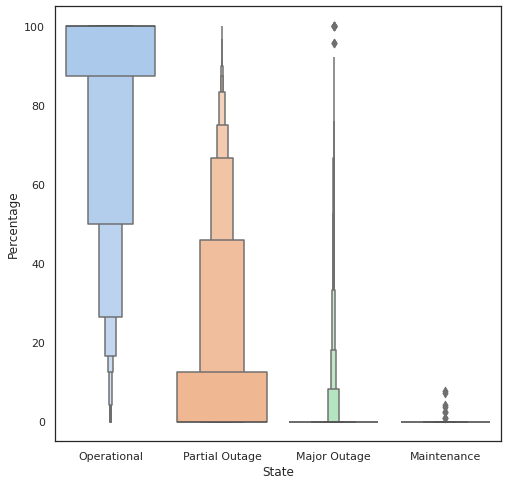

In [11]:
ax2 = sns.boxenplot(x='variable', y='value', palette='pastel', data=pd.melt(df_grp))
ax2.set(xlabel='State', ylabel='Percentage')
ax2.set_xticklabels(['Operational', 'Partial Outage', 'Major Outage', 'Maintenance'])

#### Timeseries

In [12]:
timeseries = df_grp.reset_index().pivot(index='days', columns=['source', 'service'], values='operational_pct')
# slack = df_grp.reset_index()[df_grp.reset_index()['source']=='slack']

array([[<AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>],
       [<AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        <AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>],
       [<AxesSubplot:xlabel='days'>, <AxesSubplot:xlabel='days'>,
        

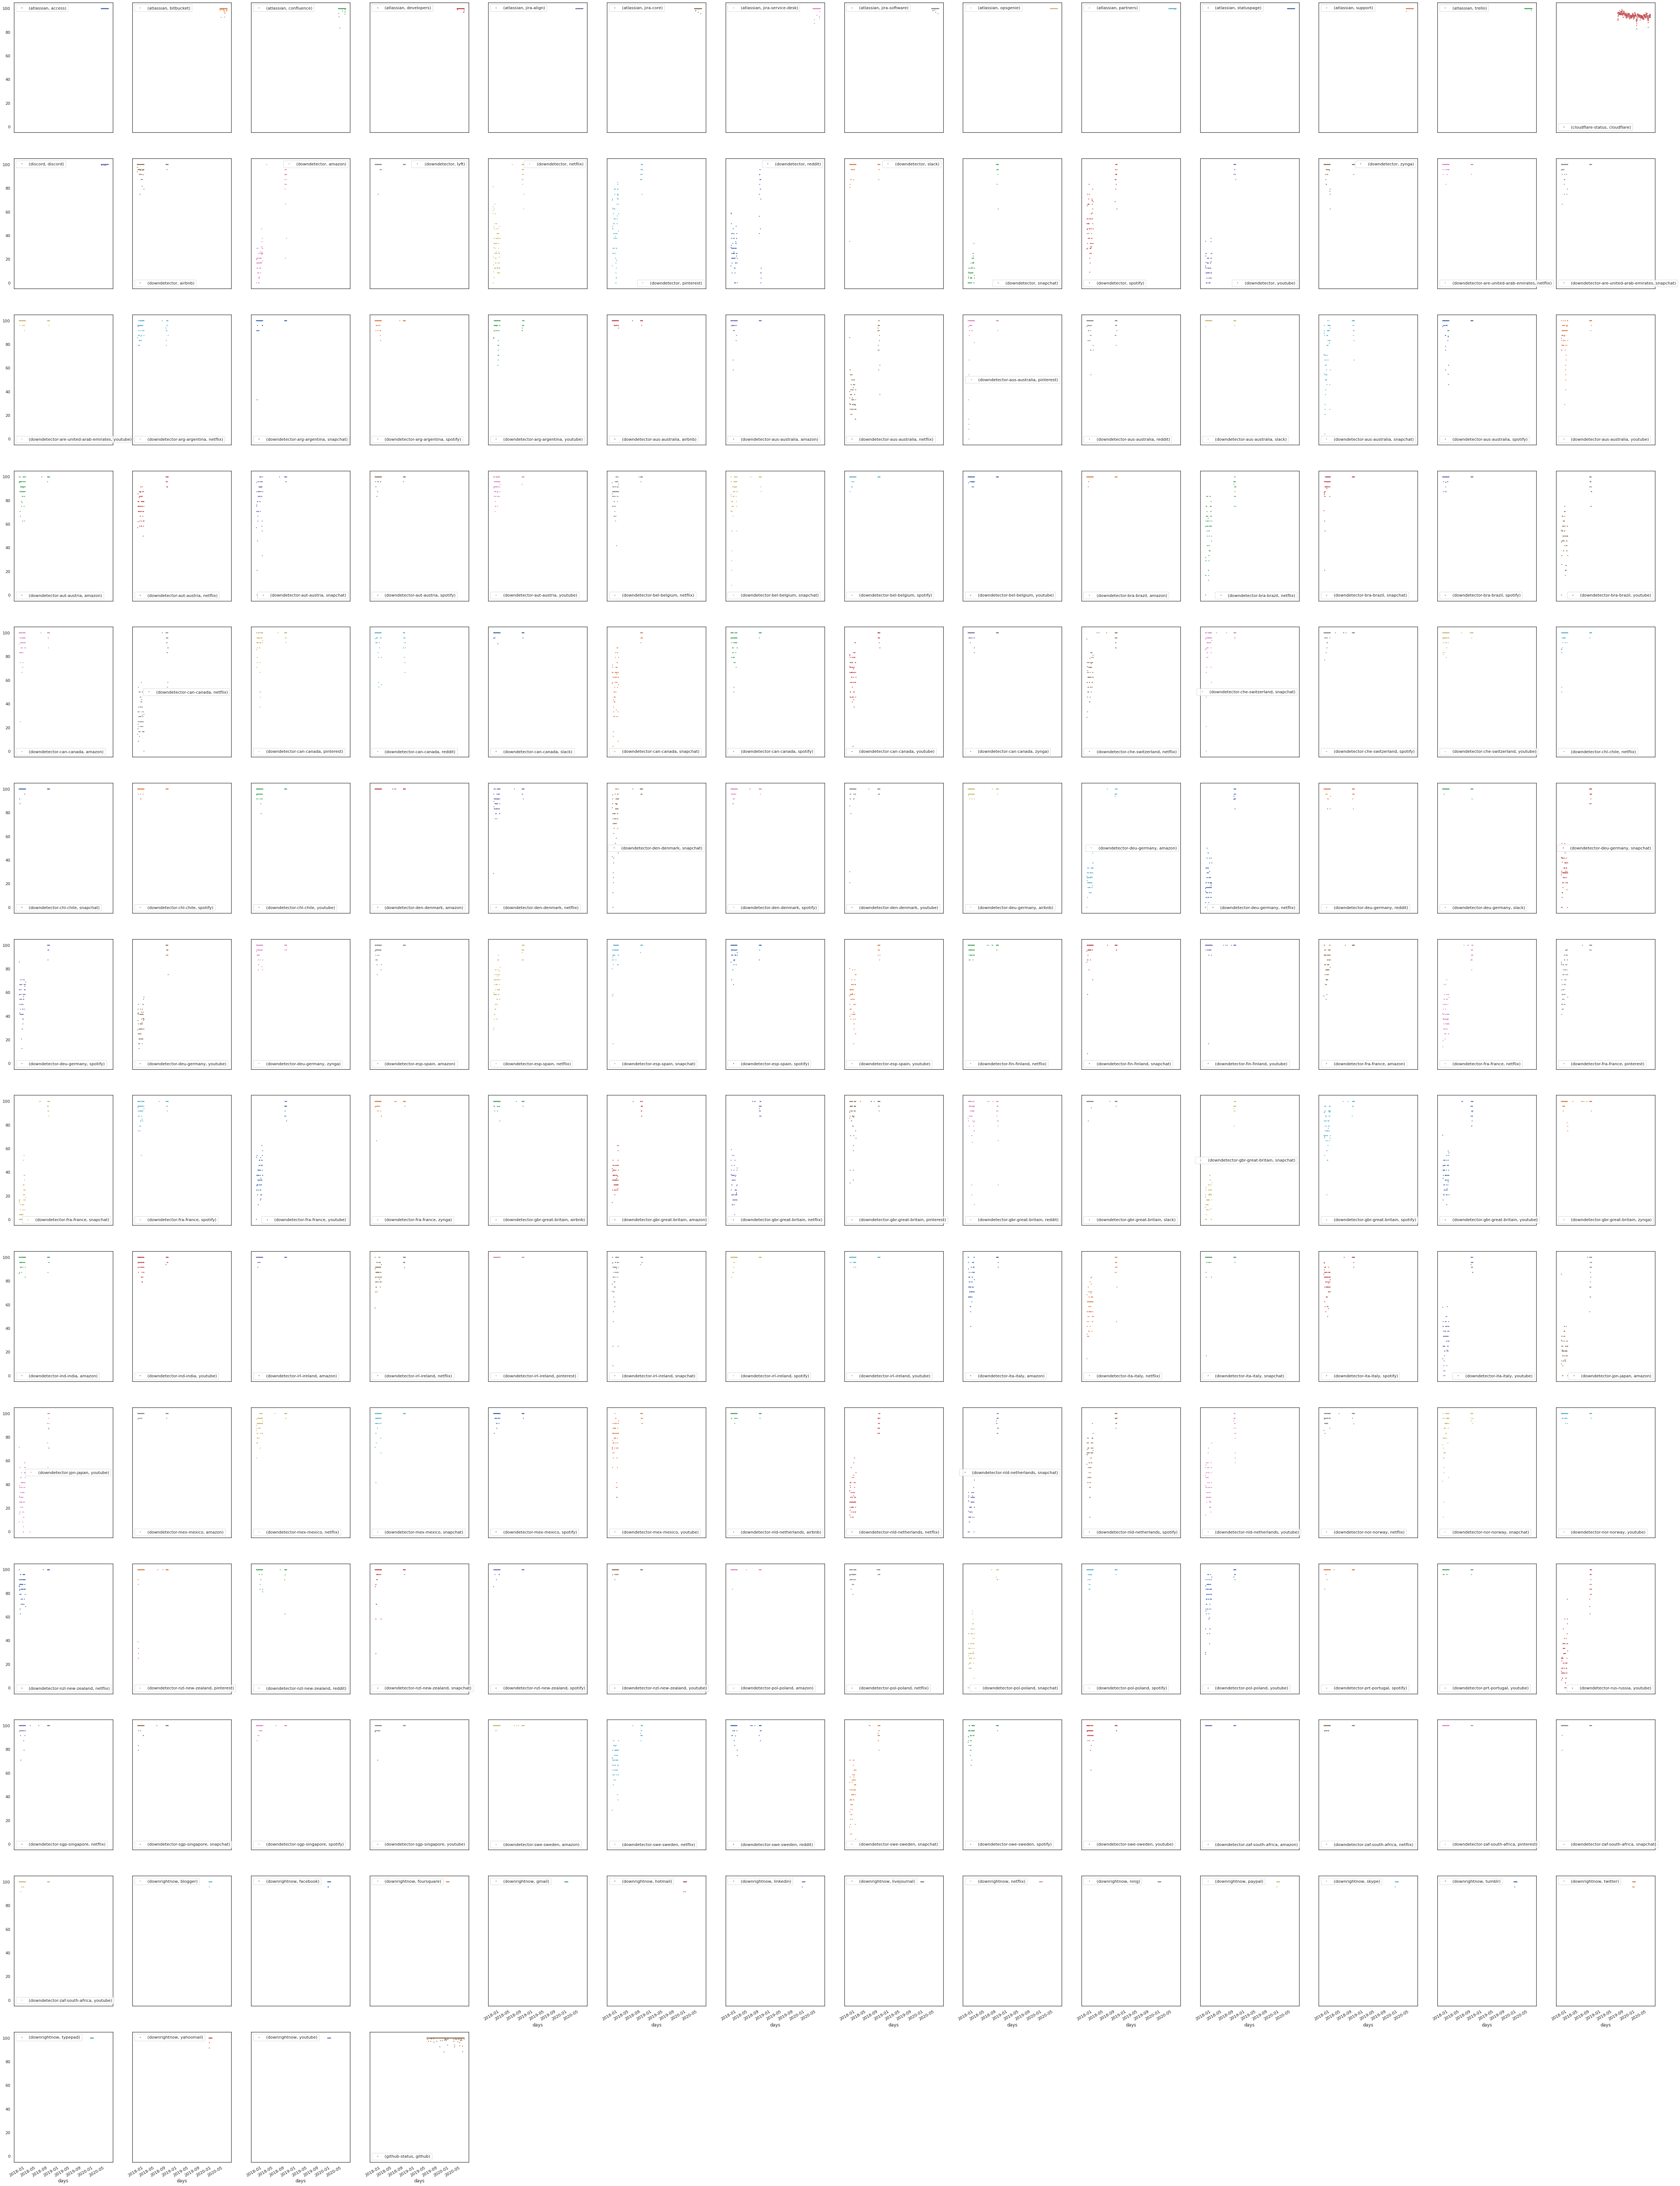

In [13]:
fig = timeseries.reset_index()
fig.plot(x = 'days', sharex=True, sharey=True, marker=".", linestyle="", markersize=3, layout = (14,14), figsize = (80, 120), subplots=True, legend=True)

## Detailed statistics

#### Frequency of status state changes per source/service

In [14]:
# df_grouped = df.groupby(['source','service'])
# df_grouped.head()

In [15]:
# first_values = df_grouped['success_pct'].first()
# first_values = first_values.reset_index()
# first_values = np.array(first_values['success_pct'])
# first_values

In [16]:
# for name, group in df_grouped:
#     if name[0] == 'cloudflare-status':
#         continue
#     x = group[group['success_pct'].diff() != 0].index.tolist()
#     print(name, len(group), len(x)-1, x)

#### MTBF per source/service